<a href="https://colab.research.google.com/github/Khan252004/Result-Management/blob/main/Anamoly_Detection_in_Network_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Isolation Forest

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


LOAD DATASET KDD Cup 1999 Data

In [67]:
# Change this path to your KDD dataset location
file_path = "kdd_data/kddcup.data_10_percent_corrected"

columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell",
    "su_attempted","num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count","srv_count",
    "serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]

# Load CSV
df = pd.read_csv(file_path, names=columns)

# Binary label: normal=0, attack=1
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)

# Encode categorical features
categorical_cols = ['protocol_type','service','flag']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Features & target
X = df.drop('label', axis=1)
y = df['label']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Dataset loaded:", X_scaled.shape)


Dataset loaded: (494021, 41)


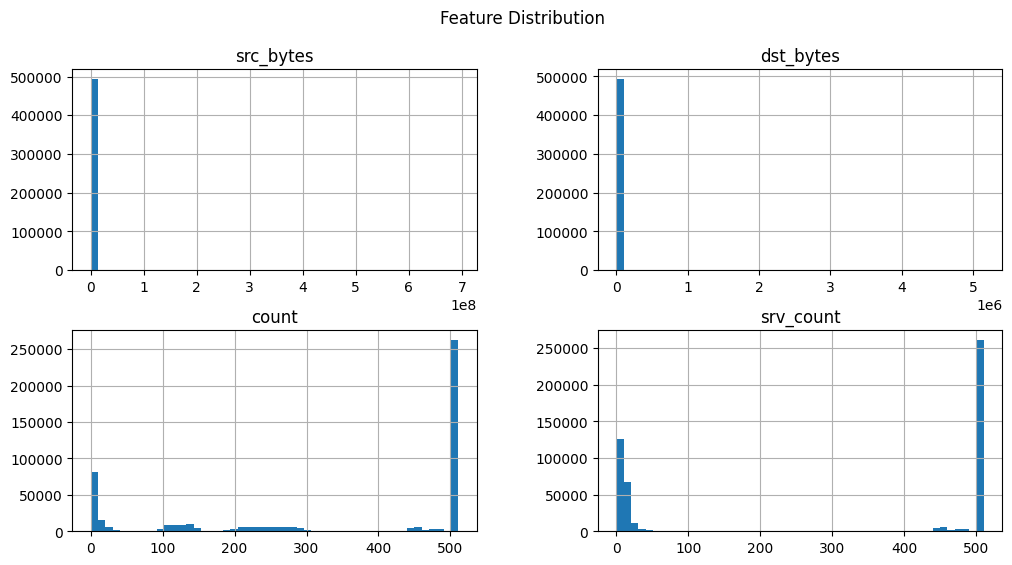

Label distribution:
 label
1    396743
0     97278
Name: count, dtype: int64


In [68]:
# Histogram of few numeric features
df[['src_bytes','dst_bytes','count','srv_count']].hist(bins=50, figsize=(12,6))
plt.suptitle("Feature Distribution")
plt.show()

# Check label distribution
print("Label distribution:\n", y.value_counts())


In [69]:
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

autoencoder.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 41)             │         1,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
X_normal = X_scaled[y==0]  # train only on normal data

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_normal, X_normal,
    epochs=50,
    batch_size=256,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0983
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0050
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0043
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0037
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024
Epoch 9/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 10/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0018
Epoch 11/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016
Epoch 12/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015
Epoch 13/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Epoch 14/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Epoch 15/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

15439/15439 ━━━━━━━━━━━━━━━━━━━━ 13s 827us/step


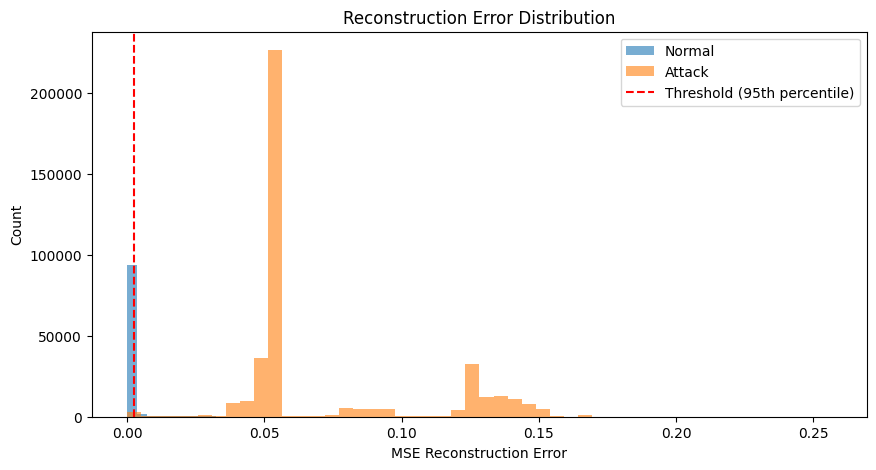

In [71]:
# Reconstruction error
X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Visualize reconstruction error
plt.figure(figsize=(10,5))
plt.hist(reconstruction_error[y==0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_error[y==1], bins=50, alpha=0.6, label='Attack')
plt.axvline(np.percentile(reconstruction_error[y==0],95), color='r', linestyle='--', label='Threshold (95th percentile)')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()


In [72]:
# Threshold = 95th percentile of normal reconstruction errors
threshold = np.percentile(reconstruction_error[y==0], 95)
preds = np.where(reconstruction_error > threshold, 1, 0)

# Results
print("[Autoencoder Results]")
print(confusion_matrix(y, preds))
print(classification_report(y, preds, zero_division=0))
print("Accuracy:", accuracy_score(y, preds))
print("F1-score (macro):", f1_score(y, preds, average='macro'))


[Autoencoder Results]
[[ 92414   4864]
 [  2530 394213]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     97278
           1       0.99      0.99      0.99    396743

    accuracy                           0.99    494021
   macro avg       0.98      0.97      0.98    494021
weighted avg       0.98      0.99      0.98    494021

Accuracy: 0.9850330249118965
F1-score (macro): 0.9761215069315463
